# Titanic Competition

*The sinking of the Titanic is one of the most infamous shipwrecks in history.*

*On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an         iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224         passengers and crew.*

*While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than      others.*

*In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely      to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)*


From the **Titanic Competition** homepage on Kaggle which can be viewed in its entirety [here](https://www.kaggle.com/c/titanic)


## Goal:
This competition requires the use of  machine learning to create a model that predicts whether or not a passenger survived the Titanic shipwreck.


## Major Steps Taken:

1. Loading data

2. Cleaning data

3. Exploring the data through visualization

3. Choosing the best model to use

5. Hyperparameter tuning of the best model

6. Making the predictions and submitting to Kaggle


In [1]:
#importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading in the data

train_data=pd.read_csv('train.csv', index_col='PassengerId')
test_data=pd.read_csv('test.csv',index_col='PassengerId')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None) 


train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(train_data.shape)

(891, 11)


In [4]:
print(test_data.shape)

(418, 10)


In [5]:
#Here is where we check for the data type and change them accordingly if not proper type
print(train_data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


In [6]:
#To see the characteristics of the numerical features

print(train_data.describe())

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


In [7]:
#To see the characteristics of the categorical features

print(train_data.describe(include=['O']))

                            Name   Sex    Ticket    Cabin Embarked
count                        891   891       891      204      889
unique                       891     2       681      147        3
top     Sage, Mr. George John Jr  male  CA. 2343  B96 B98        S
freq                           1   577         7        4      644


In [8]:
#Finding out the missing values by column

print(train_data.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


In [9]:
# Function to calculate missing values by column
def missing_values_table(df):
        
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [10]:
missing_values_table(train_data)

Your selected dataframe has 11 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [11]:

# Get the columns with > 50% missing
missing_df = missing_values_table(train_data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

# Drop the columns
train_data = train_data.drop(columns = list(missing_columns), axis=1)
test_data=test_data.drop(columns=list(missing_columns), axis=1)

Your selected dataframe has 11 columns.
There are 3 columns that have missing values.
We will remove 1 columns.


In [12]:
print(train_data.shape)

(891, 10)


In [13]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Embarked
count,891,891,891,889
unique,891,2,681,3
top,"Sage, Mr. George John Jr",male,CA. 2343,S
freq,1,577,7,644


In [14]:
#also drop the ticket column as it has too many unique values as seen above
train_data=train_data.drop(columns=['Ticket','Name'])
test_data=test_data.drop(columns=['Ticket', 'Name'])

In [15]:
print(train_data.shape)
print(test_data.shape)

(891, 8)
(418, 7)


# Exploratory Data Analysis

## Survived

In [16]:
train_data['Survived'].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Text(0, 0.5, 'Number of observations')

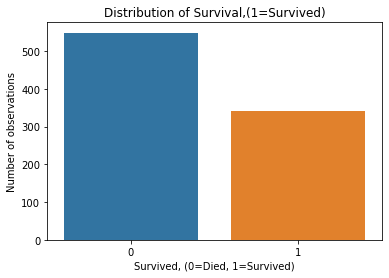

In [17]:
sns.countplot(x="Survived", data=train_data)
plt.title('Distribution of Survival,(1=Survived)')
plt.xlabel('Survived, (0=Died, 1=Survived)')
plt.ylabel('Number of observations')

More people died than survived in the titanic

## Age

Text(0, 0.5, 'Count')

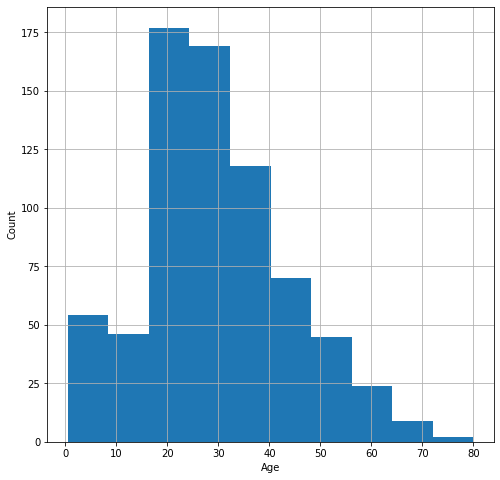

In [18]:
train_data['Age'].hist(figsize=(8,8))
plt.xlabel('Age')
plt.ylabel('Count')

Here we can see that the majority of people are between the ages of 20 and 40

<AxesSubplot:xlabel='Age'>

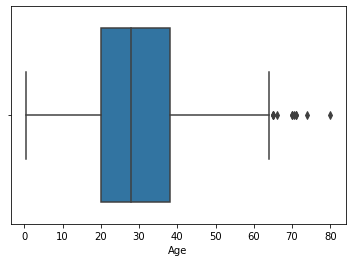

In [19]:
sns.boxplot(x="Age", data=train_data)

Here we see that the normal ages are between 1 and 65 years.With people above the ages of 65 seen as  outliers

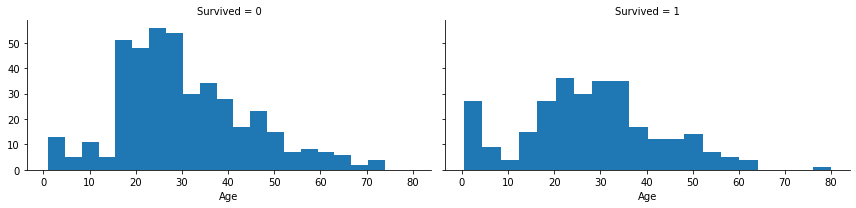

In [20]:
g = sns.FacetGrid(train_data, col='Survived',aspect=2)
g.map(plt.hist, 'Age', bins=20)

Here above we see that the majority of people who died were aged between the ages of 20 to 40, who from above we deduced to be the majority age.

## Sex

<AxesSubplot:xlabel='Sex', ylabel='count'>

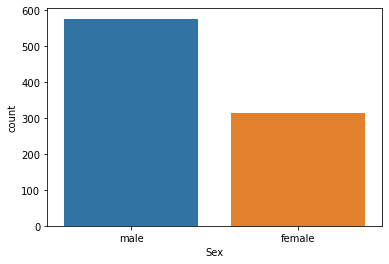

In [21]:
sns.countplot(x="Sex", data=train_data)

We see above that majority of the passengers onboard the Titanic were male

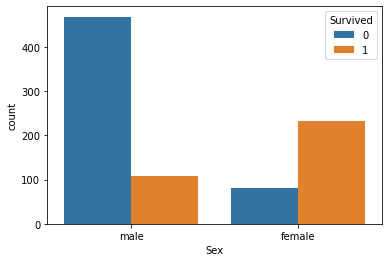

In [22]:
sns.countplot(x="Sex", hue="Survived", data=train_data);

We see from above that it is mostly the men who died from the titanic tragedy

## Pclass

<AxesSubplot:xlabel='Pclass', ylabel='count'>

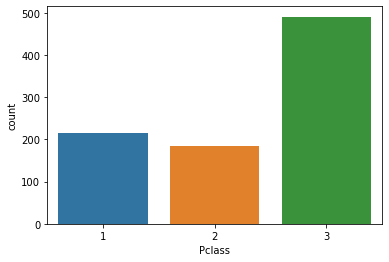

In [23]:
sns.countplot(x='Pclass', data=train_data)

Majority of the people who boarded the Titanic were in 3 class.It is also here that we expect the majority of deaths to come from

<AxesSubplot:xlabel='Pclass', ylabel='count'>

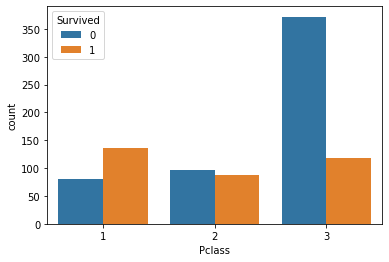

In [24]:
sns.countplot(x='Pclass', hue='Survived', data=train_data)

As expected majority of the deaths came from the third class.Could be that the class defined the chambers one stayed in and third class chambers were low thus they were exposed to water the longest.

## Fare

Text(0, 0.5, 'Count')

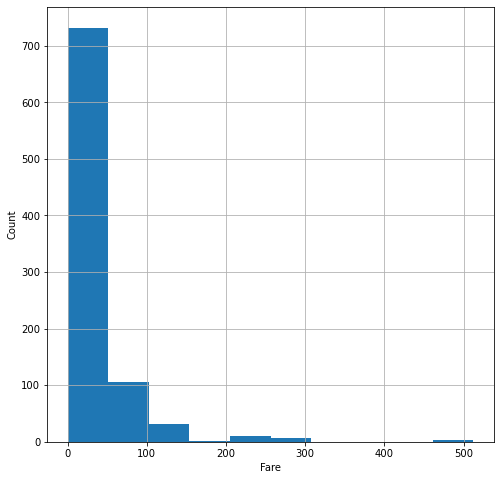

In [25]:
train_data['Fare'].hist(figsize=(8,8))
plt.xlabel('Fare')
plt.ylabel('Count')

Here we see that the cheapest fare was paid by majority of the people on board the Titanic.From earlier we saw that the majority
of the people were also from the third class.The fare explains why this is so

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

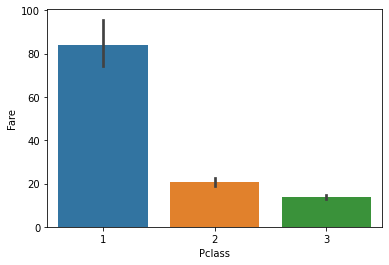

In [26]:
#sns.countplot(x='Pclass',y='Fare', data=train_data)
sns.barplot(x='Pclass',y='Fare',data=train_data)

Here we can see that the most expensive fare was paid by individuals within the first class and this explains why those indiviuals were the least within the Titanic

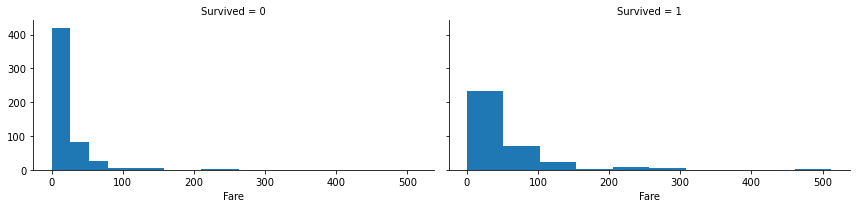

In [27]:
g = sns.FacetGrid(train_data, col='Survived',aspect=2)
g.map(plt.hist, 'Fare', bins=10)

Again this confirms that the people who died the most paid the least fare

## Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

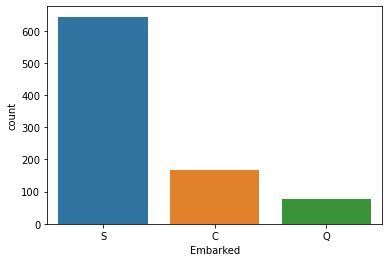

In [28]:
sns.countplot(x='Embarked', data=train_data)

Most people embarked from S.Let's see if it offered the cheapest fare

<AxesSubplot:xlabel='Embarked', ylabel='Fare'>

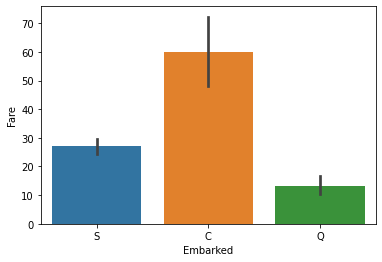

In [29]:
sns.barplot(x='Embarked',y='Fare',data=train_data)

As seen above S didnot offer the cheapest fare.There must have been another reason why people boarded into the Titanic through S

<AxesSubplot:xlabel='Embarked', ylabel='count'>

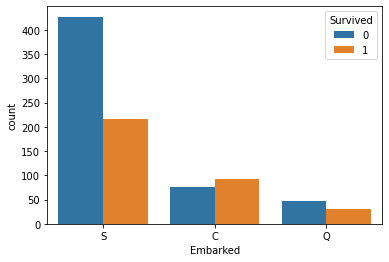

In [30]:
sns.countplot(x='Embarked', hue='Survived', data=train_data)

As expected,the majority of the people on the Titanic who died embarked through S

## Sibsp

<AxesSubplot:xlabel='SibSp', ylabel='count'>

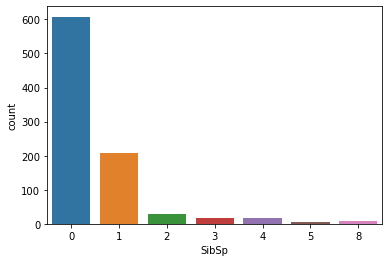

In [31]:
sns.countplot(x='SibSp', data=train_data)

majority of the people on board the titanic had no siblings or spouses

<AxesSubplot:xlabel='SibSp', ylabel='count'>

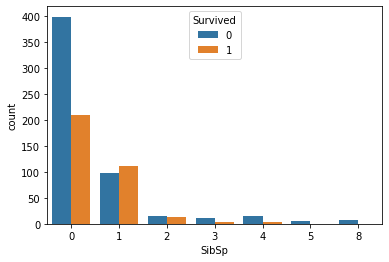

In [32]:
sns.countplot(x='SibSp',hue='Survived', data=train_data)

As expected majority of the deaths came from those without siblings or spouses

## Parch

<AxesSubplot:xlabel='Parch', ylabel='count'>

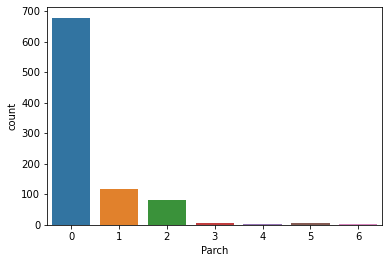

In [33]:
sns.countplot(x='Parch', data=train_data)

Majority of the people had neither parents nor children on board

<AxesSubplot:xlabel='Parch', ylabel='count'>

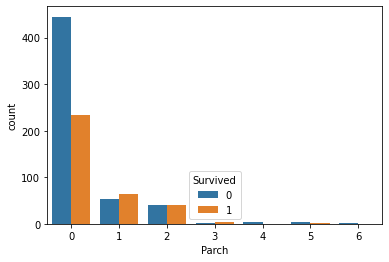

In [34]:
sns.countplot(x='Parch',hue='Survived',data=train_data)

Also as expected majority of the people who died had no parents or children

## Correlation analysis

In [35]:
correlation=train_data.corr()
print(correlation)

          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651
Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225
Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

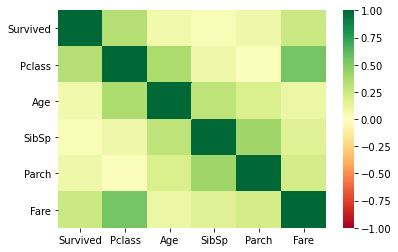

In [36]:
sns.heatmap(np.abs(correlation),          # use absolute values
        xticklabels=correlation.columns,
        yticklabels=correlation.columns,
         vmin=-1, vmax=1,cmap="RdYlGn")

Pclass, Fare have a high correlation with Survived. They themselves are also highly correlated

## Feature engineering

In [37]:
#Change the data type of the categorical features from object to category

object_columns = train_data.select_dtypes(include='object')


for column in object_columns:
    train_data[column] = train_data[column].astype('category')

    
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    category
 3   Age       714 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  889 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 83.0 KB


In [38]:
train_data2=train_data.drop(columns='Survived', axis=1)
print(train_data2.shape)

(891, 7)


In [39]:
#Separating the entire dataframe into numerical and categorical features
numerical_features = train_data2.select_dtypes(include=['int64', 'float64']).columns

categorical_features = train_data2.select_dtypes(include=['category']).columns 
print(numerical_features)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


In [40]:
#train-test-split
X=train_data2
y=train_data['Survived']

X_train,X_test,y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=1)
print(numerical_features)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


## Making a pipeline with column transformer

In [41]:
preprocessor=make_column_transformer(

             (make_pipeline(
             KNNImputer(missing_values=np.nan, n_neighbors=10, weights='distance'),
             StandardScaler()),numerical_features),
    
           
             (make_pipeline(
             SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
             OneHotEncoder(handle_unknown='ignore')),categorical_features),
    
    
)

In [42]:
#Fitting and transforming the training and testing data

preprocessor.fit_transform(X_train)
preprocessor.transform(X_test)
preprocessor.transform(test_data)

array([[ 0.81738199,  0.30830823, -0.48942917, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.81738199,  1.2139054 ,  0.49236869, ...,  0.        ,
         0.        ,  1.        ],
       [-0.38794068,  2.300622  , -0.48942917, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.81738199,  0.59809932, -0.48942917, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.81738199, -0.18433663, -0.48942917, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.81738199, -0.50941529,  0.49236869, ...,  1.        ,
         0.        ,  0.        ]])

## Choosing Best ML model

In [43]:
logreg=LogisticRegression()
svc=SVC()
knn=KNeighborsClassifier(n_neighbors=13)
random_forest=RandomForestClassifier(n_estimators=13)

classifier_model=[('LogisticRegression',logreg),('Support Vector Classification', svc),('KNeighborsClassifier', knn),('RandomForestClassifier',random_forest)]

for classifier, name in classifier_model:
    pipe=make_pipeline(preprocessor, name)
    score=cross_val_score(pipe,X,y, cv=10, scoring='accuracy').mean()
    print(f'{classifier}: {score}')

LogisticRegression: 0.8024843945068664
Support Vector Classification: 0.8260549313358302
KNeighborsClassifier: 0.8069662921348314
RandomForestClassifier: 0.8126466916354556


As seen above, the Support Vector Classification is the best model to try and predict the fates of the people on the titanic

## Hyper parameter tuning of the best model

In [44]:
svc = SVC()
parameter_grid = {
             'svc__C' : [0.001, 0.01, 0.1,100,1,10],
             'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
             'svc__gamma' : ['scale', 'auto'],
             'svc__decision_function_shape' : ['ovo', 'ovr'],
              'svc__tol': [0.001,0.003,0.005,0.009]
             }

pipe=make_pipeline(preprocessor,svc)
cross_validation = StratifiedKFold()
cross_validation.get_n_splits(y_train)
 
randomized_search = RandomizedSearchCV(pipe,
                           scoring='accuracy',
                           param_distributions=parameter_grid,
                           cv=cross_validation,
                           random_state=1,
                           verbose=1,
                           n_jobs=-1,
                           n_iter= 25)
 
randomized_search.fit(X_train, y_train)
parameters = randomized_search.best_params_
 
print(f'Best score: {randomized_search.best_score_}')
print(f'Best parameters: {randomized_search.best_params_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best score: 0.8323869374929862
Best parameters: {'svc__tol': 0.005, 'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__decision_function_shape': 'ovo', 'svc__C': 10}


## Prediction

In [45]:
y_pred=randomized_search.predict(test_data)

In [46]:

submission = pd.DataFrame({
        "PassengerId": test_data.index,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

Kaggle gave this submission an accuracy prediction of 77.272%. As I gain more information, I will make changes to improve the score.